# Solution 3.2: Solving a cantilever beam with Finite Differences

In this tutorial we will learn how to obtain the motion of a cantilever beam using Finite Differences

The equation of motion of the beam is:
$$\rho A \ddot{w} + EI w'''' = q(x,t)$$

where $w(t)$ is the deflection of the beam, $\rho$ its density, $A$ its cross-sectional area, $E$ its Young's modulus, $I$ its second moment of area and $q(x,t)$ a distributed force applied to the beam. 

The boundary conditions for a cantilever beam are:
$$ w(0) = w'(0) = \dot{w}(0) = \ddot{w}(0) = 0 $$
$$EI\ w^{'''}(L) = F_{\mathrm{ext}}(t) $$
$$EI\ w^{''}(L) = M_{\mathrm{ext}}(t) $$

## The roadmap to finde the beam deflection  using Finite Differences

The steps needed to discretize the beam are listed next. 
1. Discretize space into $N + 1$ points.
2. Discretize the EOM of the beam. To do this, you will have to approximate the 4th order derivative with FD. Use a second order approximation. You can find the coefficients [here](https://en.wikipedia.org/wiki/Finite_difference_coefficient) (or google `finite difference coefficients' and click the Wikipedia page)}.
3. Apply the boundary conditions. Use the definition of discrete derivatives and EOM to find the relation between the ghost points and the interior points.
4. Combine all equations into matrices. 
5. Solve the resulting ODE system

In [1]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp

### Step 1: Discretize space

In [2]:
# Your code goes here
L = 10
N = 10
x = np.linspace(0,L,N+1)
print(x)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


### Step 2: Discretize the EOM of the beam

Using the coefficients for a centered FD scheme for 4th order derivatives with 2nd order accuracy we have:

$$ w_i^{''''} = \frac{w_{i-2}-4w_{i-1}+6w_i-4w_{i+1}+w_{i+2}}{\Delta x^4}$$

The equivalent scheme for the 3rd order derivative is:

$$ w_i^{'''} = \frac{-0.5w_{i-2}+w_{i-1}-w_{i+1}+0.5w_{i+2}}{\Delta x^3}$$

For the 2nd order derivative:

$$ w_i^{''} = \frac{w_{i-1}-2w_i+w_{i+1}}{\Delta x^2}$$

And for the 1st order derivative:

$$ w_i^{'} = \frac{-0.5w_{i-1}+0.5w_{i+1}}{\Delta x}$$

Replacing these expressions into the equation of motion we get the discrete system:

> Your derivations go here
$$\rho A \ddot{w_i} + \frac{EI}{\Delta x^4} \left( w_{i-2}-4w_{i-1}+6w_i-4w_{i+1}+w_{i+2} \right) = q_i(t)$$

### Step 3: Apply boundary conditions

> Your derivations go here
$$ w_0 = 0$$
$$w_0' = 0$$
$$\dot{w_0} = 0$$
$$\ddot{w_0} = 0 $$
$$EI\ w_N^{'''} = F_{\mathrm{ext}}(t) $$
$$EI\ w_N^{''} = M_{\mathrm{ext}}(t) $$

So this means that:

1) i = 1 also needs i = -1: 
$$ w_i^{'} = \frac{-0.5w_{i-1}+0.5w_{i+1}}{\Delta x}$$
$$\Rightarrow  w_0^{'} = \frac{-0.5w_{-1}+0.5w_{1}}{\Delta x} = 0 $$
$$\Rightarrow w_1 = w_{-1}$$ 

2) i = N-1 also needs i = N+1:
$$ EI\ w_{N}^{''} = EI\ \frac{w_{N-1}-2w_{N}+w_{N+1}}{\Delta x^2} = M_{\mathrm{ext}} $$
$$ \Rightarrow w_{N+1} = \frac{\Delta x^2}{EI}M_{\mathrm{ext}}-w_{N-1}+2w_{N} $$

3) i = N also needs i = N+2:
$$EI\ w_N^{'''} = EI\ \frac{-0.5w_{N-2}+w_{N-1}-w_{N+1}+0.5w_{N+2}}{\Delta x^3} = F_{\mathrm{ext}} $$
$$ \Rightarrow w_{N+2} = 2\frac{\Delta x^3}{EI}F_{\mathrm{ext}}+w_{N-2}-2w_{N-1}+2w_{N+1} $$

### Step 4: Matrix form

Summarizing we have the following discrete (in space) equations:

- For $i=1$:
> Your derivations go here
$$ \rho A \ddot{w_1} + \frac{EI}{\Delta x^4} \left( 7w_1-4w_{2}+w_{3} \right) = q_1 $$
- For $i=2$:
> Your derivations go here
$$ \rho A \ddot{w_2} + \frac{EI}{\Delta x^4} \left(-4w_{1}+6w_{2}-4w_{3}+w_{4} \right) = q_2 $$
- For $i=3,...,N-2$:
> Your derivations go here
$$\rho A \ddot{w_i} + \frac{EI}{\Delta x^4} \left( w_{i-2}-4w_{i-1}+6w_i-4w_{i+1}+w_{i+2} \right) = q_i$$
- For $i=N-1$:
> Your derivations go here
$$\rho A \ddot{w_{N-1}} + \frac{EI}{\Delta x^4} \left( w_{N-3}-4w_{N-2}+5w_{N-1}-2w_{N} \right) = 
q_{N-1}-\frac{1}{\Delta x^2}M_{\mathrm{ext}}$$
- For $i=N$:
> Your derivations go here
$$\rho A \ddot{w_{N}} + \frac{EI}{\Delta x^4} \left( 2w_{N-2}-4w_{N-1}+2w_{N}\right) = 
q_{N}+\frac{1}{\Delta x^2}M_{\mathrm{ext}}-\frac{2}{\Delta x}F_{\mathrm{ext}}$$

This is equivalent to the following system in compact form:
> Your derivations go here
$$\boldsymbol{M}\ddot{\boldsymbol{w}}+\boldsymbol{K}\boldsymbol{w}=\boldsymbol{F}$$
with vectors  $\boldsymbol{w}$ and $\boldsymbol{F}$, and matrices $\boldsymbol{M}$ and $\boldsymbol{K}$ equal to:

$$ \boldsymbol{w} = \left[  {\begin{array}{c}
                                w_1 \\ w_2 \\ w_3 \\ \vdots \\ w_{N-2} \\ w_{N-1} \\ w_{N}
                            \end{array}} 
                    \right]
$$

$$ \boldsymbol{M} = \left[  {\begin{array}{ccccc}
                                \rho A & 0 & \cdots & 0 \\
                                0 & \rho A & \cdots & 0 \\
                                \vdots & \vdots & \vdots & \ddots \\
                                0 & 0 & \cdots & \rho A \\
                            \end{array}} 
                    \right]
$$

$$ \boldsymbol{K} = \frac{EI}{\Delta x^4}
                    \left[  {\begin{array}{ccccccccccc}
                                7 & -4 & 1 &  0 & 0 & \cdots & 0 & 0 & 0 & 0 & 0 \\
                                -4 & 6 & -4 & 1 & 0 & \cdots & 0 & 0 & 0 & 0 & 0 \\
                                1 & -4 & 6 & -4 & 1 & \cdots & 0 & 0 & 0 & 0 & 0 \\
                                \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots \\
                                0 & 0 & 0 & 0 & 0 & \cdots & 1 & -4 & 6 & -4 & 1 \\
                                0 & 0 & 0 & 0 & 0 & \cdots & 0 & 1 & -4 & 5 & -2 \\
                                0 & 0 & 0 & 0 & 0 & \cdots & 0 & 0 & 2 & -4 & 2 \\
                            \end{array}} 
                    \right]
$$

$$ \boldsymbol{F} = \left[  {\begin{array}{c}
                                q_1 \\ q_2 \\ q_3 \\ \vdots \\ q_{N-2} \\
                                q_{N-1}-\frac{1}{\Delta x^2}M_{\mathrm{ext}} \\
                                q_N + \frac{1}{\Delta x^2}M_{\mathrm{ext}}-\frac{2}{\Delta x}F_{\mathrm{ext}}
                            \end{array}} 
                    \right]
$$



Some info for the coming exercises:

In [3]:
def qfunc(x_i,t): # Can choose whatever you need, x are the free node coordinates in an array, so here without w_0
    return (x_i[1:]**2 - 3*x_i[1:] - 1)*np.sin(t) * 1e2
def F_ext(t):
    return 1e3 *np.cos(t)
def M_ext(t):
    return 1e4 *(np.sin(t)+np.cos(t))
rho = 7850 # kg/m3, steel

b = 0.2
h = 0.5
A = b*h # m2
E = 1 # For increased stability
EI = 1/3*b*h**3*E

In [4]:
# Construct the matrices and external force vector
DeltaX = L/N
def Ffunc(t):
    q_part = qfunc(x,t)    
    ext_part = np.zeros(N)
    ext_part[-2:] = [-M_ext(t)/DeltaX**2, M_ext(t)/DeltaX**2-2*F_ext(t)/DeltaX]
    return q_part + ext_part

M = np.diag(rho*A*np.ones(N))

K = np.zeros((N,N))
K[0,0:3] = [-7, -4, 1]
K[1,0:4] = [-4, 6, -4, 1]
for i in range(2,N-2):
    K[i,i-2:i+3] = [1, -4, 6, -4, 1]
K[-2,-4:] = [1, -4, 5, -2]
K[-1,-3:] = [2, -4, 2]
K = (EI/DeltaX**4) * K

# Step 5: Solve the ODE system

Now, we just need to apply what we learned in the previous session to solve the dynamic problem. The main novelty is that here we work with matrices.

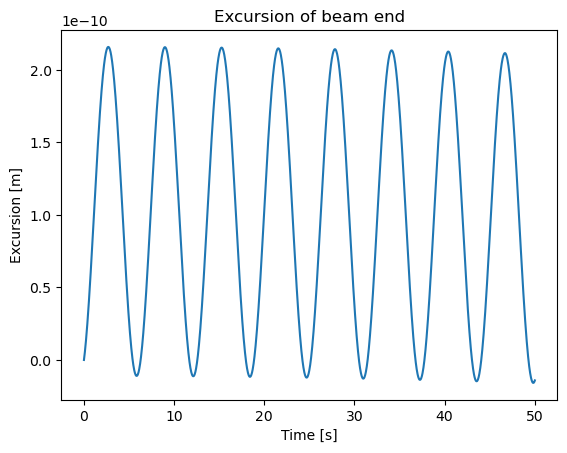

In [5]:
# Define the ODE function
M_inv = np.linalg.inv(M)
def fun(t,dispvelo):
    u = dispvelo[:N]
    v = dispvelo[N:]
    a = (M_inv @ (Ffunc(t) - K @ u)) # @ determines the dit productm, M_inv is just unit matrix
    return np.concatenate((v, a))

# Define initial state
dispvelo0 = np.zeros(2*N)

# Define time interval and time evaluation points
t0 = 0
tf = 50

# Solve
sol = solve_ivp(fun,t_span=[t0, tf],y0=dispvelo0,method="Radau",t_eval=np.linspace(t0,tf,2000))

# Plot
E = 210e9
plt.plot(sol.t,sol.y[-1]/E)
plt.xlabel("Time [s]")
plt.ylabel("Excursion [m]")
plt.title("Excursion of beam end");


## Exercise: Add a point mass at the extreme of the beam

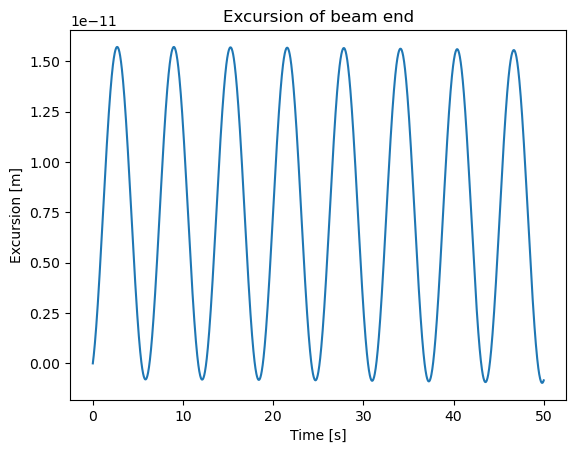

In [6]:
# Only 1 change: a point mass m on the mass matrix
m = 10e3 # 10 tons
M = np.diag(rho*A*np.ones(N))
M[-1,-1] += m

M_inv = np.linalg.inv(M)
def fun(t,dispvelo):
    u = dispvelo[:N]
    v = dispvelo[N:]
    a = (M_inv @ (Ffunc(t) - K @ u)) # @ determines the dit productm, M_inv is just unit matrix
    return np.concatenate((v, a))

# Define initial state
dispvelo0 = np.zeros(2*N)

# Define time interval and time evaluation points
t0 = 0
tf = 50

# Solve
sol = solve_ivp(fun,t_span=[t0, tf],y0=dispvelo0,method="Radau",t_eval=np.linspace(t0,tf,2000))

# Plot
E = 210e9
plt.plot(sol.t,sol.y[-1]/E)
plt.xlabel("Time [s]")
plt.ylabel("Excursion [m]")
plt.title("Excursion of beam end");